## Bitcoin data crawling

In [4]:
from binance_historical_data import BinanceDataDumper 
import datetime 
import os 
import pandas as pd 

data_dumper = BinanceDataDumper(
    path_dir_where_to_dump="Data", # save data in "Data" folder
    asset_class="spot", # spot market 
    data_type="klines", # "klines" means candlestick data
    data_frequency='1m' # 1 minute frequency
)

# Download historical data for BTCUSDT from Jan 1, 2024 to now 
start_date = datetime.datetime(2024, 1, 1)
data_dumper.dump_data(
    tickers=["BTCUSDT"],
    date_start=datetime.date(2024, 1, 1),
    date_end=None, # None means up to current date
    is_to_update_existing=False # do not update existing data files
)

print("Data download completed.")

---> Found overall tickers: 3436
---> Filter to asked tickers: 1
------> Tickers left: 1
Download full data for 1 tickers: 
---> Data will be saved here: d:\Tài liệu học tập\Khai phá và phân tích dữ liệu\Group Assignment\Notebooks\Data\spot
---> Data Frequency: 1m
---> Start Date: 20240101
---> End Date: 20251202


Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/23 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/2 [00:00<?, ?files/s]

Tried to dump data for 1 tickers:
---> For BTCUSDT new data saved for: 23 months 2 days
Data download completed.


### Integrate Bitcoin data

In [11]:
import pandas as pd
import numpy as np  # Needed for the efficient "where" condition
import os

# 1. Setup paths
base_dir = "Data"
target_path_1 = os.path.join(base_dir, "spot", "monthly", "klines", "BTCUSDT", "1m")
target_path_2 = os.path.join(base_dir, "spot", "daily", "klines", "BTCUSDT", "1m")

column_names = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignored"
]

def load_data(path):
    if not os.path.exists(path):
        return []
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
    # Read without headers
    return [pd.read_csv(f, header=None, names=column_names) for f in files]

# 2. Load and Combine
print("Loading data...")
df_list = load_data(target_path_1) + load_data(target_path_2)

if not df_list:
    raise ValueError("No data found!")

df_combined = pd.concat(df_list, ignore_index=True)

# 3. Normalize Mixed Timestamps
# ---------------------------------------------------------
# Logic: A timestamp in 2024/2025 is ~1.7 trillion in ms (13 digits).
# In microseconds, it is ~1.7 quadrillion (16 digits).
# We set a threshold: if number > 10 trillion (10^13), it must be microseconds.
# ---------------------------------------------------------

# Ensure column is numeric first
df_combined['open_time'] = pd.to_numeric(df_combined['open_time'])

# Divide by 1000 ONLY where the number is huge (microseconds)
df_combined['open_time'] = np.where(
    df_combined['open_time'] > 10_000_000_000_000,  # Threshold
    df_combined['open_time'] / 1000,                # Action if True (convert us to ms)
    df_combined['open_time']                        # Action if False (keep as ms)
)

# 4. Convert to Datetime (Now everything is milliseconds)
print("Converting timestamps...")
df_combined['open_time'] = pd.to_datetime(df_combined['open_time'], unit='ms')

# 5. Clean, Sort, and Save
df_combined = df_combined.sort_values(by='open_time').drop_duplicates(subset=['open_time']).reset_index(drop=True)
df_combined = df_combined.drop(columns=['ignored', 'close_time'])  # Drop 'ignored' column

output_file = "Data/bitcoin_data_combined.csv"
df_combined.to_csv(output_file, index=False)

print(f"Success! Saved to {output_file}")
print(f"Total Rows: {len(df_combined)}")
print(f"Start Date: {df_combined['open_time'].min()}")
print(f"End Date:   {df_combined['open_time'].max()}")

Loading data...
Converting timestamps...
Success! Saved to Data/bitcoin_data_combined.csv
Total Rows: 1010880
Start Date: 2024-01-01 00:00:00
End Date:   2025-12-02 23:59:00


In [12]:
df_combined

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724,1.519032e+06,1327,23.18766,9.803947e+05
1,2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,8.955809e+05,1348,13.47483,5.700808e+05
2,2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,9.143711e+05,1019,11.21801,4.747986e+05
3,2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,1.291997e+06,1241,24.04878,1.018449e+06
4,2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,1.951945e+06,1415,34.12804,1.446539e+06
...,...,...,...,...,...,...,...,...,...,...
1010875,2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2.307065e+06,2474,14.38350,1.313551e+06
1010876,2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1.717544e+06,1757,8.01604,7.322544e+05
1010877,2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,5.729914e+05,1171,0.52385,4.784345e+04
1010878,2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,9.955555e+05,1438,2.07823,1.897387e+05


## Data Understanding

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df = pd.read_csv("Data/bitcoin_data_combined.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# Feature engineering 
df['returns'] = df['close'].pct_change()

# Log returns 
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# Volatility (Percentage difference between high and low of that minute)
df['intra_volatility'] = (df['high'] - df['low']) / df['low']
df['intra_volatility'] = df['intra_volatility'] * 100  # convert to percentage
df['intra_volatility'].fillna(0, inplace=True)

# Volume in USD
df['volume_usd'] = df['volume'] * df['close']

df.dropna(inplace=True)

print("Data Loaded and Features Engineered.")
df.head()


Data Loaded and Features Engineered.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5752\2868332003.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['intra_volatility'].fillna(0, inplace=True)


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,log_returns,intra_volatility,volume_usd
open_time,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.620000,42320.000000,42298.610000,42320.000000,21.167790,895580.861046,1348,13.474830,570080.794218,0.000506,0.000506,0.050569,895820.872800
2024-01-01 00:02:00,42319.990000,42331.540000,42319.990000,42325.500000,21.603910,914371.138186,1019,11.218010,474798.587411,0.000130,0.000130,0.027292,914396.292705
2024-01-01 00:03:00,42325.500000,42368.000000,42325.490000,42367.990000,30.507300,1291996.946516,1241,24.048780,1018449.084939,0.001004,0.001003,0.100436,1292532.981327
2024-01-01 00:04:00,42368.000000,42397.230000,42367.990000,42397.230000,46.051070,1951945.192303,1415,34.128040,1446539.293896,0.000690,0.000690,0.069014,1952437.806536
2024-01-01 00:05:00,42397.220000,42409.200000,42385.260000,42409.200000,32.267660,1368040.009889,1255,20.990930,889944.494398,0.000282,0.000282,0.056482,1368445.646472


### Descriptive Statistics

In [60]:
def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

# General summary 
desc_stats = df[['close', 'volume_usd', 'returns', 'intra_volatility']].describe()
desc_stats = desc_stats.transpose()
desc_stats = desc_stats.applymap(format)
# remove count column
desc_stats = desc_stats.drop(columns=['count'])

# skewness and kurtosis
skew = df[['returns', 'intra_volatility']].skew()
kurt = df[['returns', 'intra_volatility']].kurtosis()

print("Descriptive Statistics:")
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print(desc_stats)

print("\nSkewness:")
print(skew)
print("\nKurtosis:")
print(kurt)


Descriptive Statistics:
                          mean           std         min          25%  \
close                83,516.71     22,685.75   38,558.92    63,864.52   
volume_usd        1,561,769.16  2,681,257.24    5,071.14   400,191.89   
returns             0.00000100    0.00069493     -0.0429  -0.00027876   
intra_volatility        0.0678        0.0760  0.00000798       0.0241   

                         50%           75%             max  
close              84,705.33    104,305.82      126,114.50  
volume_usd        823,059.47  1,716,043.58  256,885,789.27  
returns           0.00000000    0.00028143          0.0291  
intra_volatility      0.0486        0.0876          6.7873  

Skewness:
returns            -0.658823
intra_volatility    7.902973
dtype: float64

Kurtosis:
returns             67.881945
intra_volatility   276.230122
dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5752\4066055266.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats = desc_stats.applymap(format)


### Visualization

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set a professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Ensure index is datetime 
if not isinstance(df.index, pd.DatetimeIndex):
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

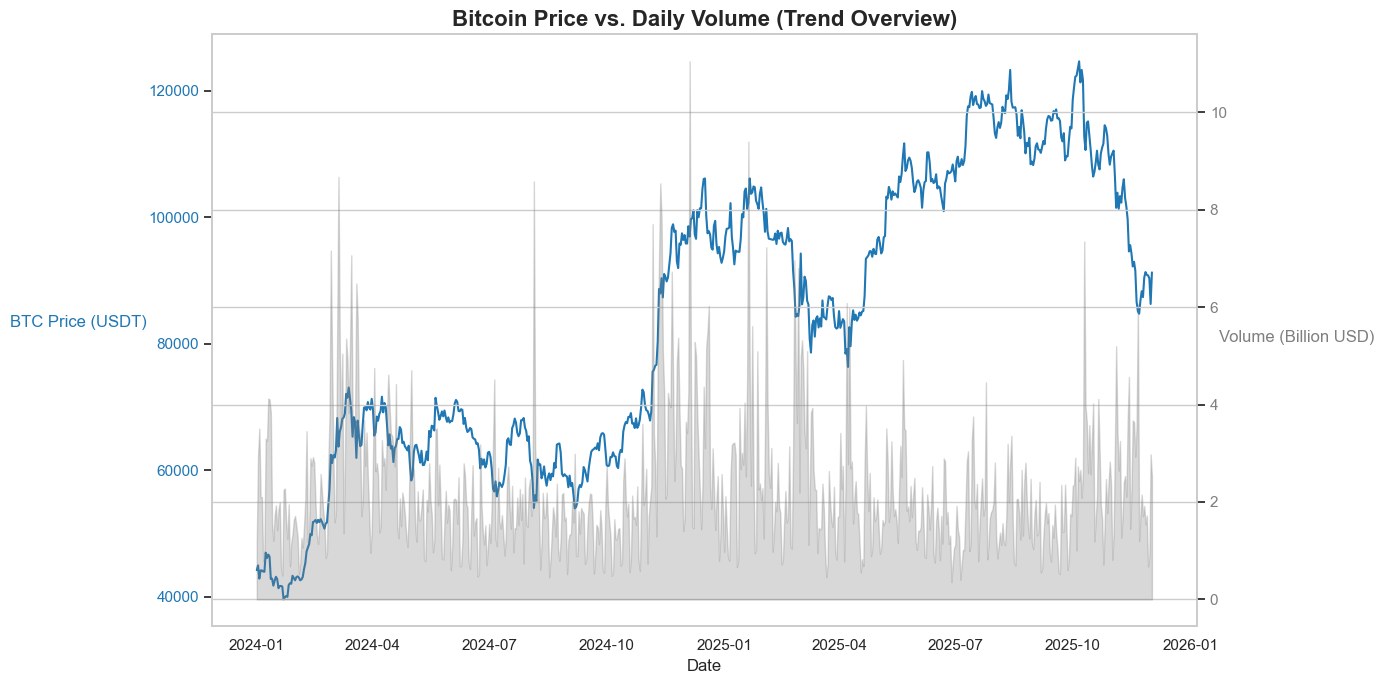

In [62]:
# Resample to Daily average for a clean trend line
df_daily = df.resample('D').agg({
    'close': 'last', 
    'volume_usd': 'sum'
})

# change volume to billions for better readability
df_daily['volume_usd'] = df_daily['volume_usd'] / 1_000_000_000  # in billions

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Price on Left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USDT)', color=color, rotation=0, labelpad=50)
ax1.plot(df_daily.index, df_daily['close'], color=color, linewidth=1.5, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False) # Turn off grid for price to keep it clean

# Create a second Y-axis for Volume
ax2 = ax1.twinx()  
color = 'tab:gray'
ax2.set_ylabel('Volume (Billion USD)', color=color, rotation=0, labelpad=50)
ax2.fill_between(df_daily.index, df_daily['volume_usd'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Title and Layout
plt.title('Bitcoin Price vs. Daily Volume (Trend Overview)', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

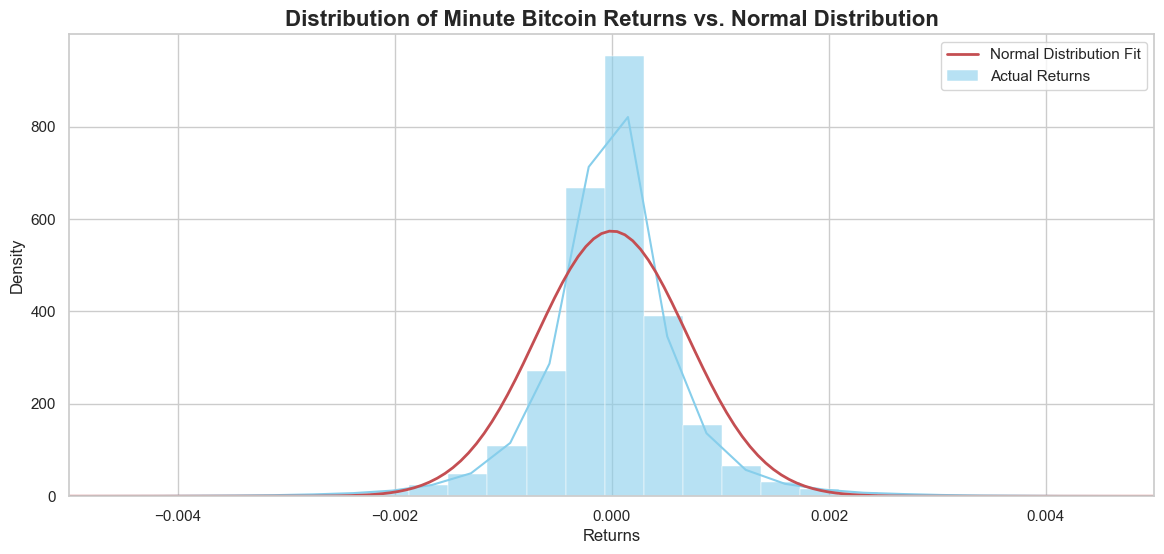

In [63]:
from scipy.stats import norm 

plt.figure(figsize=(14, 6))

# plot the actual data histogram
sns.histplot(df['returns'], bins=200, kde=True, stat="density", color='skyblue', label='Actual Returns', alpha=0.6)

# plot the normal distribution curve    
mu, std = norm.fit(df['returns'])
x = np.linspace(df['returns'].min(), df['returns'].max(), 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Fit')

plt.xlim(-0.005, 0.005) # Focus on central part

plt.title('Distribution of Minute Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

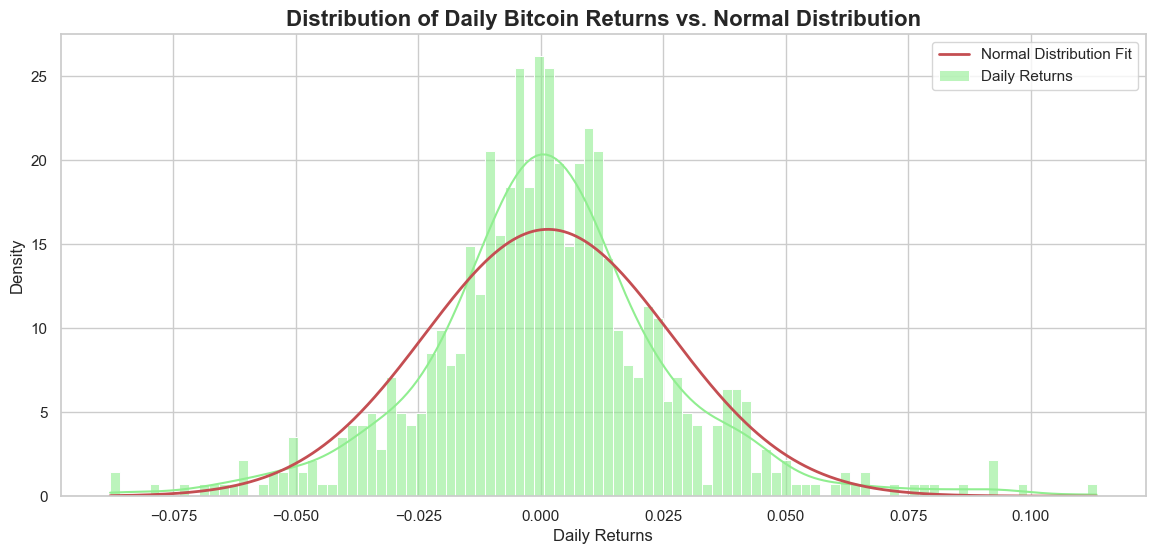

In [64]:
# distribution of daily returns
plt.figure(figsize=(14, 6))
sns.histplot(df.resample('D')['returns'].sum(), bins=100, kde=True, stat="density", color='lightgreen', label='Daily Returns', alpha=0.6)

# plot the normal distribution curve
mu_daily, std_daily = norm.fit(df.resample('D')['returns'].sum())
x_daily = np.linspace(df.resample('D')['returns'].sum().min(), df.resample('D')['returns'].sum().max(), 1000)
p_daily = norm.pdf(x_daily, mu_daily, std_daily)
plt.plot(x_daily, p_daily, 'r', linewidth=2, label='Normal Distribution Fit')


plt.title('Distribution of Daily Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

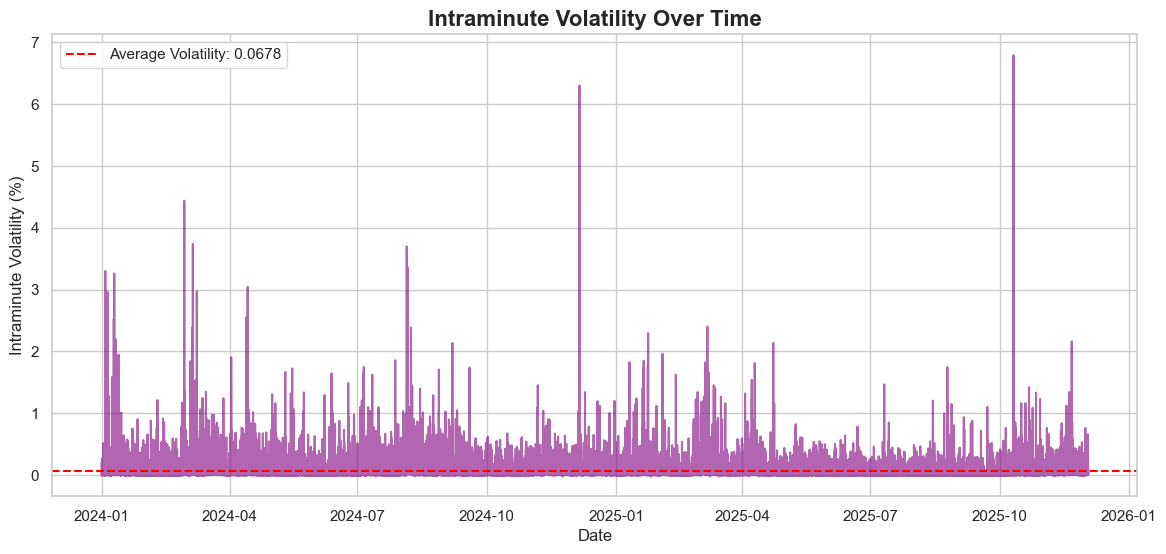

In [65]:
# Volatility Clustering 
plt.figure(figsize=(14, 6))

plt.plot(df.index, df['intra_volatility'], color='purple', alpha=0.6)

plt.title('Intraminute Volatility Over Time', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Intraminute Volatility (%)')

avg_vol = df['intra_volatility'].mean()
plt.axhline(avg_vol, color='red', linestyle='--', label=f'Average Volatility: {avg_vol:.4f}')
plt.legend()

plt.show()

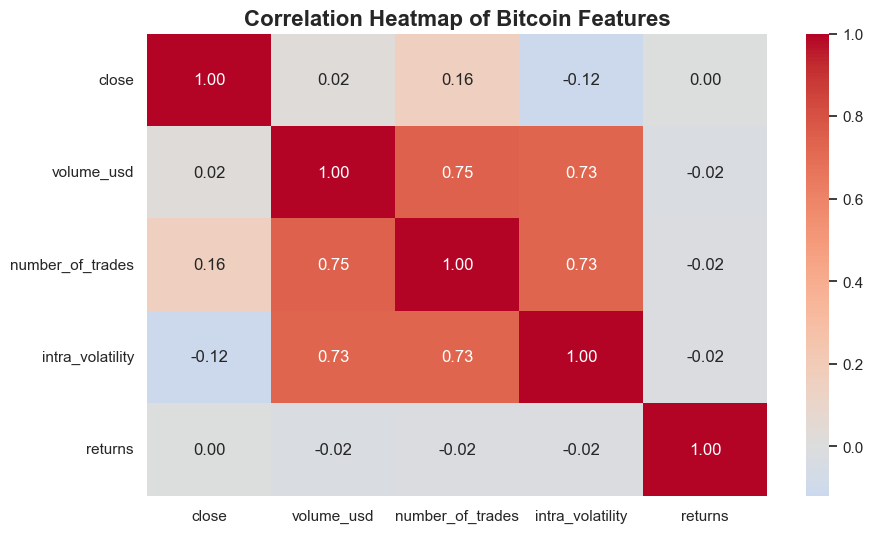

In [83]:
# Heatmap for Multivariate Correlation
corr = df[['close', 'volume_usd', 'number_of_trades', 'intra_volatility', 'returns']].corr()



plt.figure(figsize=(10, 6))

# draw heatmap  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Bitcoin Features', fontsize=16, weight='bold')
plt.show()

## Feature Engineering for Analysis

### Standard Indicators (RSI, EMA, ATR)

In [85]:
df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSI - 14 period
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss 
df['rsi_14'] = 100 - (100 / (1 + rs))

# ATR - 14 period 
high_low = df['high'] - df['low']
high_close = np.abs(df['high'] - df['close'].shift())
low_close = np.abs(df['low'] - df['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
df['atr_14'] = true_range.rolling(window=14).mean()

# Shock Volume
df['vol_ma20'] = df['volume_usd'].rolling(window=20).mean()
df['is_shock_vol'] = np.where(df['volume_usd'] > 2 * df['vol_ma20'], 1, 0)

df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol
open_time,,,,,,,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.620000,42320.000000,42298.610000,42320.000000,21.167790,895580.861046,1348,13.474830,570080.794218,0.000506,0.000506,0.050569,895820.872800,42320.000000,42320.000000,NaN,NaN,NaN,0
2024-01-01 00:02:00,42319.990000,42331.540000,42319.990000,42325.500000,21.603910,914371.138186,1019,11.218010,474798.587411,0.000130,0.000130,0.027292,914396.292705,42320.215686,42320.054726,NaN,NaN,NaN,0
2024-01-01 00:03:00,42325.500000,42368.000000,42325.490000,42367.990000,30.507300,1291996.946516,1241,24.048780,1018449.084939,0.001004,0.001003,0.100436,1292532.981327,42322.089189,42320.531694,NaN,NaN,NaN,0
2024-01-01 00:04:00,42368.000000,42397.230000,42367.990000,42397.230000,46.051070,1951945.192303,1415,34.128040,1446539.293896,0.000690,0.000690,0.069014,1952437.806536,42325.035887,42321.294861,NaN,NaN,NaN,0
2024-01-01 00:05:00,42397.220000,42409.200000,42385.260000,42409.200000,32.267660,1368040.009889,1255,20.990930,889944.494398,0.000282,0.000282,0.056482,1368445.646472,42328.336441,42322.169539,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 23:55:00,91299.990000,91354.820000,91272.000000,91349.180000,25.264300,2307065.338604,2474,14.383500,1313551.276239,0.000539,0.000539,0.090740,2307873.088274,91557.348874,91588.987370,35.627112,43.109286,1225093.505328,0
2025-12-02 23:56:00,91349.170000,91354.680000,91332.690000,91338.340000,18.801960,1717543.912360,1757,8.016040,732254.375825,-0.000119,-0.000119,0.024077,1717339.815146,91548.760290,91586.493367,35.874651,43.514286,1274543.243833,0
2025-12-02 23:57:00,91338.340000,91338.340000,91313.070000,91313.070000,6.273800,572991.355009,1171,0.523850,47843.446250,-0.000277,-0.000277,0.027674,572879.938566,91539.517534,91583.772736,32.963432,44.894286,1258975.083020,0


### MARKET STRUCTURE (Fractals: HH, LL)

In [86]:
window = 5 

df['is_swing_high'] = df['high'].rolling(window=window, center=True).max() == df['high']
# local low 
df['is_swing_low'] = df['low'].rolling(window=window, center=True).min() == df['low']

# fill the NaNs created by rolling with False 
df['is_swing_high'] = df['is_swing_high'].fillna(False)
df['is_swing_low'] = df['is_swing_low'].fillna(False)

df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,...,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low
open_time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.620000,42320.000000,42298.610000,42320.000000,21.167790,895580.861046,1348,13.474830,570080.794218,0.000506,...,0.050569,895820.872800,42320.000000,42320.000000,NaN,NaN,NaN,0,False,False
2024-01-01 00:02:00,42319.990000,42331.540000,42319.990000,42325.500000,21.603910,914371.138186,1019,11.218010,474798.587411,0.000130,...,0.027292,914396.292705,42320.215686,42320.054726,NaN,NaN,NaN,0,False,False
2024-01-01 00:03:00,42325.500000,42368.000000,42325.490000,42367.990000,30.507300,1291996.946516,1241,24.048780,1018449.084939,0.001004,...,0.100436,1292532.981327,42322.089189,42320.531694,NaN,NaN,NaN,0,False,False
2024-01-01 00:04:00,42368.000000,42397.230000,42367.990000,42397.230000,46.051070,1951945.192303,1415,34.128040,1446539.293896,0.000690,...,0.069014,1952437.806536,42325.035887,42321.294861,NaN,NaN,NaN,0,False,False
2024-01-01 00:05:00,42397.220000,42409.200000,42385.260000,42409.200000,32.267660,1368040.009889,1255,20.990930,889944.494398,0.000282,...,0.056482,1368445.646472,42328.336441,42322.169539,NaN,NaN,NaN,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 23:55:00,91299.990000,91354.820000,91272.000000,91349.180000,25.264300,2307065.338604,2474,14.383500,1313551.276239,0.000539,...,0.090740,2307873.088274,91557.348874,91588.987370,35.627112,43.109286,1225093.505328,0,False,True
2025-12-02 23:56:00,91349.170000,91354.680000,91332.690000,91338.340000,18.801960,1717543.912360,1757,8.016040,732254.375825,-0.000119,...,0.024077,1717339.815146,91548.760290,91586.493367,35.874651,43.514286,1274543.243833,0,False,False
2025-12-02 23:57:00,91338.340000,91338.340000,91313.070000,91313.070000,6.273800,572991.355009,1171,0.523850,47843.446250,-0.000277,...,0.027674,572879.938566,91539.517534,91583.772736,32.963432,44.894286,1258975.083020,0,False,False


### SMART MONEY CONCEPTS (Order Blocks, Fair Value Gaps)

In [87]:
prev_high = df['high'].shift(2)
prev_low = df['low'].shift(2)

df['is_fvg_bullish'] = (df['low'] > prev_high) & (df['close'] > df['open']) # Green candle gap
df['is_fvg_bearish'] = (df['high'] < prev_low) & (df['close'] < df['open']) # Red candle gap

# order blocks
# calculate body size and wicks
df['body_size'] = np.abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - np.maximum(df['close'], df['open'])
df['lower_wick'] = np.minimum(df['close'], df['open']) - df['low']

# Hammer / Bullish Reversal Candle 
df['is_bullish_pinbar'] = (
    (df['lower_wick'] > 2 * df['body_size']) & 
    (df['is_shock_vol'] == 1)
)

# Shooting Star / Bearish Reversal Candle (Potential Supply Zone)
df['is_bearish_pinbar'] = (
    (df['upper_wick'] > 2 * df['body_size']) & 
    (df['is_shock_vol'] == 1)
)
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,...,is_shock_vol,is_swing_high,is_swing_low,is_fvg_bullish,is_fvg_bearish,body_size,upper_wick,lower_wick,is_bullish_pinbar,is_bearish_pinbar
open_time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.620000,42320.000000,42298.610000,42320.000000,21.167790,895580.861046,1348,13.474830,570080.794218,0.000506,...,0,False,False,False,False,21.380000,0.000000,0.010000,False,False
2024-01-01 00:02:00,42319.990000,42331.540000,42319.990000,42325.500000,21.603910,914371.138186,1019,11.218010,474798.587411,0.000130,...,0,False,False,False,False,5.510000,6.040000,0.000000,False,False
2024-01-01 00:03:00,42325.500000,42368.000000,42325.490000,42367.990000,30.507300,1291996.946516,1241,24.048780,1018449.084939,0.001004,...,0,False,False,True,False,42.490000,0.010000,0.010000,False,False
2024-01-01 00:04:00,42368.000000,42397.230000,42367.990000,42397.230000,46.051070,1951945.192303,1415,34.128040,1446539.293896,0.000690,...,0,False,False,True,False,29.230000,0.000000,0.010000,False,False
2024-01-01 00:05:00,42397.220000,42409.200000,42385.260000,42409.200000,32.267660,1368040.009889,1255,20.990930,889944.494398,0.000282,...,0,False,False,True,False,11.980000,0.000000,11.960000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 23:55:00,91299.990000,91354.820000,91272.000000,91349.180000,25.264300,2307065.338604,2474,14.383500,1313551.276239,0.000539,...,0,False,True,False,False,49.190000,5.640000,27.990000,False,False
2025-12-02 23:56:00,91349.170000,91354.680000,91332.690000,91338.340000,18.801960,1717543.912360,1757,8.016040,732254.375825,-0.000119,...,0,False,False,False,False,10.830000,5.510000,5.650000,False,False
2025-12-02 23:57:00,91338.340000,91338.340000,91313.070000,91313.070000,6.273800,572991.355009,1171,0.523850,47843.446250,-0.000277,...,0,False,False,False,False,25.270000,0.000000,0.000000,False,False


In [91]:
# clean up 
df_clean = df.dropna()

df_clean.to_csv("Data/bitcoin_data_feature_engineered.csv", index=False)

In [92]:
# Preview important columns
cols = ['open_time', 'close', 'rsi_14', 'is_shock_vol', 'is_fvg_bullish', 'is_swing_low']
print(df_clean.reset_index()[cols].tail(10))

                  open_time        close    rsi_14  is_shock_vol  \
1010839 2025-12-02 23:50:00 91414.150000 37.801783             0   
1010840 2025-12-02 23:51:00 91394.140000 38.568962             0   
1010841 2025-12-02 23:52:00 91373.100000 46.417537             0   
1010842 2025-12-02 23:53:00 91352.890000 40.644020             0   
1010843 2025-12-02 23:54:00 91299.990000 29.857044             0   
1010844 2025-12-02 23:55:00 91349.180000 35.627112             0   
1010845 2025-12-02 23:56:00 91338.340000 35.874651             0   
1010846 2025-12-02 23:57:00 91313.070000 32.963432             0   
1010847 2025-12-02 23:58:00 91299.990000 34.868987             0   
1010848 2025-12-02 23:59:00 91277.880000 34.111374             0   

         is_fvg_bullish  is_swing_low  
1010839           False         False  
1010840           False         False  
1010841           False         False  
1010842           False         False  
1010843           False         False  
1010844    